Kali ini akan dilakukan simulasi gempa berdasarkan persamaan penjalaran gelombang dengan metode turunan numerik finite difference. Model dengan dimensi tertentu memiliki beberapa parameter seperti kecepatan gelombang p dan s, massa jenis medium. Pada script ini digunakan boundary yang bersifat absorbing (absorbing boundary) atau bersifat menyerap energi.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#dimensi model dalam meter
nx = 400
ny = 400
dx = 10
dy = 10 

In [ ]:
#parameter fabric elastis
vp = 2500 * np.ones((ny, nx))                        # kecepatan gelombang p atau gelombang kompresional, [m/s]
vs = vp / (3**0.5)                                   # kecepatan gelombang s atau shear, [m/s]
massa_jenis = 2800 * np.ones(vp.shape)               # massa jenis atau densitas, [kg/m3]

In [ ]:
#parameter Lame
lam = massa_jenis*(vp**2 - 2*vs**2)                  # parameter Lame pertama
mu = massa_jenis*vs**2                               # parameter modulus shear, [N/m2]

In [ ]:
t_total = 1.1                                        # parameter waktu tempuh atau rekam, [s]
dt = 0.8/(vp.max() * (1/dx**2 + 1/dy**2)**0.5)
nt = round(t_total/dt)                               # banyaknya step, atau lompatan rekaman
t = range(0,nt)*dt

In [ ]:
frekuensi = 10                                              # frekuensi wavelet Gaussian
delay = 1 / frekuensi                                       # waktu eksekusi gaya
amplitudo = 10**10                                          # waktu eksekusi gaya
sudut_gaya = 90                                             # orientasi spasial

sumber_x = round(nx/2)                                      # titik gaya pada sumbu x
sumber_y = round(ny/2)                                      # titik gaya pada sumbu y

a = (np.pi*frekuensi)**2
dt2_massa_jenis_src = dt**2/massa_jenis[sumber_y, sumber_x]   
gauss = amplitudo * np.exp(-a*(t-delay)**2)                 # persamaan wavelet Gaussian

gaya_x = np.sin(sudut_gaya * np.pi / 180) * gauss * dt2_massa_jenis_src / (dx * dy) # vektor gaya pada sumbu x
gaya_y = np.cos(sudut_gaya * np.pi / 180) * gauss * dt2_massa_jenis_src / (dx * dy) # vektor gaya pada sumbu y

In [ ]:
# absorbing boundary (dengan tepi spons dan fabric atau layer elastis)

abs_thick = min(np.floor(0.15*nx), np.floor(0.15*ny))       # ketebalan fabric atau layer
abs_rate = 0.3/abs_thick                                    # tingkat decay atau pereduksian

lmargin = [abs_thick, abs_thick]
rmargin = [abs_thick, abs_thick]
bobot = np.ones((ny+2,nx+2))

for iy in range(ny+2):
    for ix in range(nx+2):
        i = 0
        j = 0
        k = 0
        if (ix < lmargin[0] + 1):
            i = lmargin[0] + 1 - ix
        if (iy < lmargin[1] + 1):
            k = lmargin[1] + 1 - iy
        if (nx - rmargin[0] < ix):
            i = ix - nx + rmargin[0]
        if (ny - rmargin[1] < iy):
            k = iy - ny + rmargin[1]
        rr = abs_rate**2 * np.double(i*i + j*j + k*k )
        bobot[iy,ix] = np.exp(-rr)

In [ ]:
# membuat matriks untuk vektor komponen x (ux1, ux2, dan ux3) dan komponen y (uy1, uy2, dan uy3)

ux1 = np.zeros((ny+2,nx+2))
ux2 = np.zeros((ny+2,nx+2))
ux3 = np.zeros((ny+2,nx+2))
uy1 = np.zeros((ny+2,nx+2))
uy2 = np.zeros((ny+2,nx+2))
uy3 = np.zeros((ny+2,nx+2))

# membuat koefisien untuk turunan solusi numerik
co_dxx = 1/dx**2
co_dyy = 1/dy**2
co_dxy = 1/(4.0 * dx * dy)
co_dyx = 1/(4.0 * dx * dy)
dt2_massa_jenis=(dt**2)/massa_jenis
lam_2mu = lam + 2 * mu

In [ ]:
umax=[]
umax_time=[]

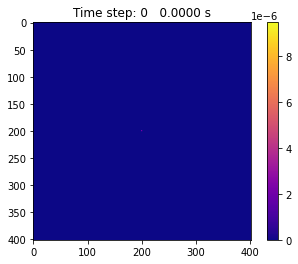

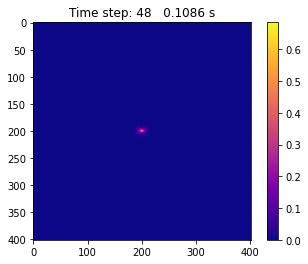

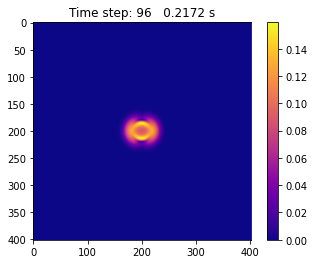

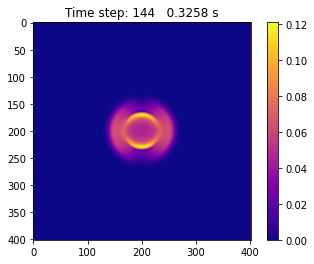

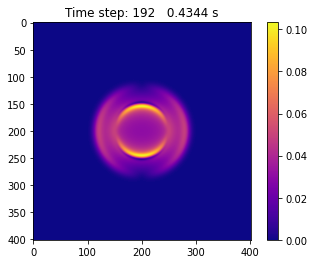

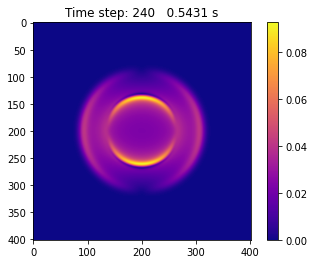

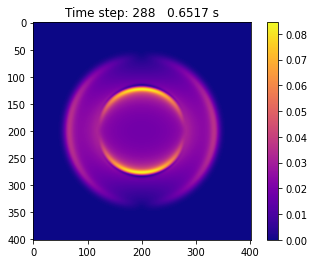

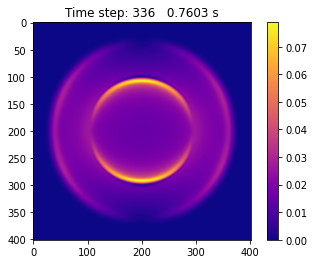

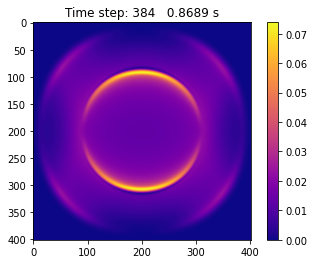

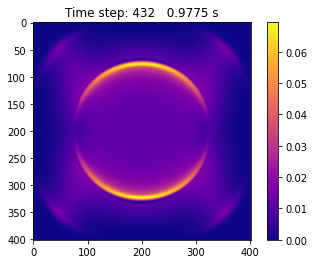

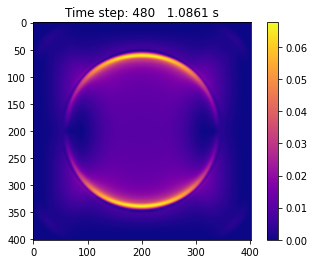

In [ ]:
# membuat koefisien untuk turunan solusi numerik
for iter in range(0,nt):
    ux3 = np.zeros(ux2.shape)
    uy3 = np.zeros(uy2.shape)
    # turunan orde dua
    # Ux
    dux_dxx = co_dxx * (ux2[1:-1,0:-2] - 2*ux2[1:-1,1:-1] + ux2[1:-1,2:])
    dux_dyy = co_dyy * (ux2[0:-2,1:-1] - 2*ux2[1:-1,1:-1] + ux2[2:,1:-1])
    dux_dxy = co_dxy * (ux2[0:-2,2:] - ux2[2:,2:]- ux2[0:-2,0:-2] + ux2[2:,0:-2])

    # Uy
    duy_dxx = co_dxx * (uy2[1:-1,0:-2] - 2*uy2[1:-1,1:-1] + uy2[1:-1,2:])
    duy_dyy = co_dyy * (uy2[0:-2,1:-1] - 2*uy2[1:-1,1:-1] + uy2[2:,1:-1])
    duy_dxy = co_dxy * (uy2[0:-2,2:] - uy2[2:,2:]- uy2[0:-2,0:-2] + uy2[2:,0:-2])

    # Komponen vektor stress pada x dan y
    sigmas_ux = lam_2mu * dux_dxx + lam * duy_dxy + mu * (dux_dyy + duy_dxy)
    sigmas_uy = mu * (dux_dxy + duy_dxx) + lam * dux_dxy + lam_2mu * duy_dyy

    # U(t) = 2*U(t-1) - U(t-2) + G dt2/rho
    ux3[1:-1,1:-1] = 2.0*ux2[1:-1,1:-1] - ux1[1:-1,1:-1] + sigmas_ux*dt2_massa_jenis
    uy3[1:-1,1:-1] = 2.0*uy2[1:-1,1:-1] - uy1[1:-1,1:-1] + sigmas_uy*dt2_massa_jenis

    # menambahkan sumber gaya
    ux3[sumber_y, sumber_x] = ux3[sumber_y, sumber_x] + gaya_x[iter]
    uy3[sumber_y, sumber_x] = uy3[sumber_y, sumber_x] + gaya_y[iter]

    # menukar data antara t-2 (1), t-1 (2) dan t (3) serta menerapkan ABS
    ux1 = ux2 * bobot
    ux2 = ux3 * bobot
    uy1 = uy2 * bobot
    uy2 = uy3 * bobot

    u=(ux3**2 + uy3**2)**0.5        # resultan vektor u

    umax.append(max(u.flatten()))
    umax_time.append(t[iter])

    if iter%48==0:
      plt.imshow(u,cmap='plasma',aspect='equal')
      plt.title('Time step: %d   %.4f s'%(iter,t[iter]))
      plt.colorbar()
      plt.show()

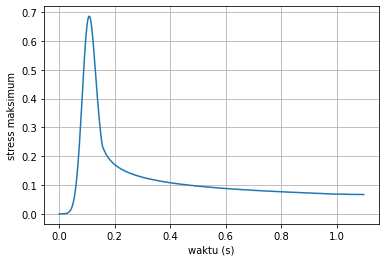

In [ ]:
plt.plot(umax_time,umax)
plt.grid()
plt.xlabel('waktu (s)')
plt.ylabel('stress maksimum')
plt.show()